In [1]:
# Import modules
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from census import Census
from us import states
import os
import warnings
warnings.filterwarnings('ignore')

# Hyperlocal Weather

The goal of this notebook is to evaluate available data sources for hyperlocal weather data. Because this notebook will be exploritory in nature, we will not be downloading the data but rather creating code that can be used to access the data at any location at the most granular level possible.

# 1. Indiana ASOS weather station network

The Indiana ASOS weather station network is a group of automated weather stations around Indiana (and across the country) that are available as well through Iowa State University Mesonet which is a large repository of a variety of weather data. Exploring the Mesonet API would be a potential future project in itself but this notebook will not go into detail with that source.
Indiana ASOS: https://www.indianamap.org/datasets/d2b7ba08e8904d5abeb3ea682a3a27ef_97/explore?location=40.054201%2C-86.402181%2C7.59&showTable=true
Iowa State Mesonet: https://mesonet.agron.iastate.edu/request/download.phtml

In [2]:


data = gpd.read_file('ASOS_Weather_Station_Network_Locations_2023.geojson')  
data.crs
print(type(data))

<class 'geopandas.geodataframe.GeoDataFrame'>


In [3]:
data.head()

,fid,id,name,network,begints,url,faaurl,geometry
0,1,AID,ANDERSON MUNICIP,IN_ASOS,1984-08-16,https://mesonet.agron.iastate.edu/sites/site.p...,https://www.aviationweather.gov/metar/data?ids...,POINT (-85.61300 40.10862)
1,2,ANQ,Angola,IN_ASOS,2013-05-06,https://mesonet.agron.iastate.edu/sites/site.p...,https://www.aviationweather.gov/metar/data?ids...,POINT (-85.08350 41.63971)
2,3,GWB,Auburn,IN_ASOS,2008-02-27,https://mesonet.agron.iastate.edu/sites/site.p...,https://www.aviationweather.gov/metar/data?ids...,POINT (-85.06437 41.30717)
3,4,HLB,Batesville,IN_ASOS,2017-09-28,https://mesonet.agron.iastate.edu/sites/site.p...,https://www.aviationweather.gov/metar/data?ids...,POINT (-85.25830 39.34451)
4,5,BFR,Bedford,IN_ASOS,2022-11-16,https://mesonet.agron.iastate.edu/sites/site.p...,https://www.aviationweather.gov/metar/data?ids...,POINT (-86.44541 38.84001)


The above dataframe lists URL access points for each weather station. The URL Mesonet.argon.iastate.edu is a weather data site run by Iowa State University and appears to have several types of weather data from local weather stations across the US. The site has an API and may be useful for this project but they pointed to other sources that may be better so I decided to look into the National Weather Service first.

# 2 NWSApY Python library for National Weather Service API

This python library is a connector to the the National Weather Service API. At the time of writing, there weren't any severe weather notices to retrieve but below we can verify that the connection is working and the app seems like it could be useful for any application where we want to trigger certain actions based on current weather warnings.

In [2]:
# !pip install nwsapy
from nwsapy import api_connector
import pandas as pd

api_connector.set_user_agent("Crisis Technology Inovation Lab", "pvstewar@iu.edu")
server_ping = api_connector.ping_server()

# Always a good idea to check to make sure an error didn't occur.
# There are times when a 400 or 500 error will occur.
if server_ping.has_any_request_errors:
    print(f"Error from server. Details: {server_ping}")
else:
    print(server_ping.status)  # will print OK

OK


- The library has a list of available requests here: https://nwsapy.readthedocs.io/en/latest/using_nwsapy/api_ref/user_api.html 
- Here is a list of the currently available and roadmap of planned end points: https://nwsapy.readthedocs.io/en/latest/using_nwsapy/endpoints.html#endpoints-dashboard

Here are some examples of what can be accessed. With the alert requests we will only see output if there are current active alerts.

To create a dataframe of all active Tornado warnings:

In [3]:
api_connector.set_user_agent("Crisis Technology Innovation Lab", "pvstewar@iu.edu")
active_tor_warnings = api_connector.get_active_alerts(event = "Tornado Warning")
df = pd.DataFrame(active_tor_warnings)
df.head()

""


To create a dataframe of all active Storm Watches:

In [4]:
api_connector.set_user_agent("Crisis Technology Innovation Lab", "pvstewar@iu.edu")
active_storm_watch = api_connector.get_active_alerts(event = "Storm Watch")
df = pd.DataFrame(active_storm_watch)
df.head()

""


The library also integrates the point information from the API which allows a user to access metadata about the closest NWS weather station to a given latitude/longitude point.

In [5]:
from geopy.geocoders import Nominatim
address = 'Indianapolis, IN'

geolocator = Nominatim(user_agent="HL_weather")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinate of Indianapolis are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Indianapolis are 39.7683331, -86.1583502.


In [ ]:
lat = latitude
lon = longitude
api_connector.set_user_agent("Crisis Technology Innovation Lab", "****@iu.edu")
point_info = api_connector.get_point(lat, lon)
df = pd.DataFrame(point_info)

In [7]:
df

,0,1
0,@id,"https://api.weather.gov/points/39.7683,-86.1584"
1,@type,wx:Point
2,cwa,IND
3,forecastOffice,https://api.weather.gov/offices/IND
4,gridId,IND
5,gridX,58
6,gridY,69
7,forecast,"https://api.weather.gov/gridpoints/IND/58,69/f..."
8,forecastHourly,"https://api.weather.gov/gridpoints/IND/58,69/f..."
9,forecastGridData,"https://api.weather.gov/gridpoints/IND/58,69"


This tools may become more valuable in the future but at this point it is mainly an access point to the NWS API that is somewhat limited in scope. This does offer some insight into how the NWS API works but most creating a connection directly to the NWS API may be more fruitful in the long run. A future group may also want to get involved in this or another open source project as a way to connect a more extensive tool using the API.

## 3. Meteostat Python library

Meteostat is a python library that offers historical weather data as well as current data based on point locations or weather station locations. If a latitude and longitude point is provided meteostat will use weather data from the nearest station or it can use a weighted average based on the nearby station information. It also factors in altitude so this can be provided in the request or if it isn't provided meteostat uses the altitude of nearby stations by default.
- Homepage: https://meteostat.net/en/
- Getting started: https://dev.meteostat.net/python/#installation

The example below gathers data on a geocode point for Indianapolis returning the daily average temperature for the year 2018:

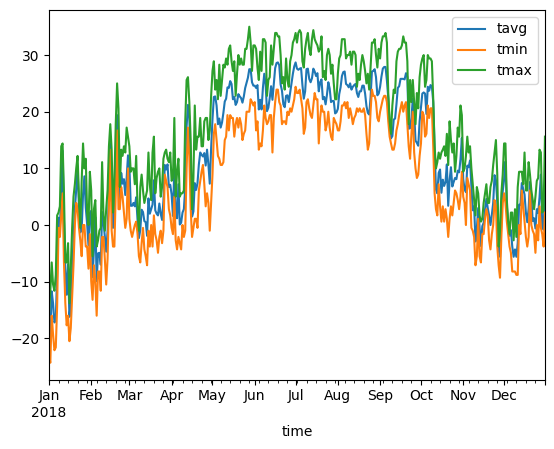

In [12]:
# Import Meteostat library and dependencies
# !pip install meteostat
from datetime import datetime
import matplotlib.pyplot as plt
from meteostat import Point, Daily

# Set time period
start = datetime(2018, 1, 1)
end = datetime(2018, 12, 31)

# Create Point for Indianapolis
Indianapolis = Point(lat, lon)

# Get daily data for 2018
data = Daily(Indianapolis, start, end)
data = data.fetch()

# Plot line chart including average, minimum and maximum temperature
data.plot(y=['tavg', 'tmin', 'tmax'])
plt.show()

Meteostat also offers the ability to get station information for a given point. Here is an example:

In [8]:
# Import Meteostat library
from meteostat import Stations

# Get nearby weather stations
stations = Stations()
stations = stations.nearby(lat, lon)
station = stations.fetch(1)

# Print DataFrame
print(station)

                                      name country region    wmo  icao  \
id                                                                       
72438  Indianapolis International  Airport      US     IN  72438  KIND   

       latitude  longitude  elevation                      timezone  \
id                                                                    
72438   39.7167   -86.1167      243.0  America/Indiana/Indianapolis   

      hourly_start hourly_end daily_start  daily_end monthly_start  \
id                                                                   
72438   1942-10-06 2023-12-10  1942-10-06 2023-12-05    1942-01-01   

      monthly_end     distance  
id                              
72438  2022-01-01  6756.072975  


In this case the closest point to the lat and lon values we provided were Indianapolis International Airport and it shows the elevation is 243. This also tells us that this point started keeping daily temperature records on October 06 1942.

Another functionality available with Meteostat is climate normal. This method collects average temperatures per month for a 30 year period. It seems that you have to specify a the years as shown below and it can't just be any 30 year period of time. So 1971 to 2000 or 1981 to 2010 will work but 1982 to 2011 will not.

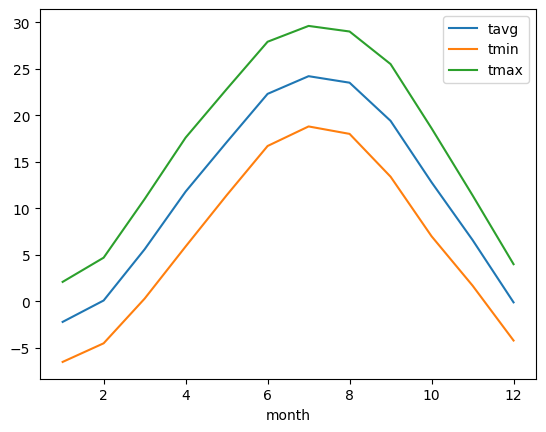

In [24]:
# Import Meteostat library and dependencies
from datetime import datetime
import matplotlib.pyplot as plt
from meteostat import Normals

# Get Normals data
data = Normals('72438', 1981, 2010)
data = data.fetch()

# Plot line chart including average, minimum and maximum temperature
data.plot(y=['tavg', 'tmin', 'tmax'])
plt.show()

This notebook was intended to explore some of the sources available for weather information. There are many sources available and these sources may not be the absolute best for all purposes. It's the hope that this notebook may serve as a reference point for future groups trying to organize and understand the capabilities that are out there for weather data integration. 

Of the sources above Meteostat seems to hold the most promise since it can gather a variety of data for any point on the map and it does some additional work in estimating for points that don't happen to line up with weather stations. This library may also serve as an example for what the Hyperlocal project could turn into in the future. What Metostat has done is to capture publicly available data, devise an algorithm for making that data more granular and therefore more hyperlocal, and then they have repackaged that system for use in development with python and for direct access to the public from a web application.

I hope the above starter code is helpful to someone in the future and I would invite future students to add to this notebook if they find other weather data sources of value.